In [ ]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 드라이브 내 데이터 폴더 위치
folder_path ='/content/drive/MyDrive/5-1/ESAA/dacon_card_data' # 지현

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv(f'{folder_path}/train.csv')
test = pd.read_csv(f'{folder_path}/test.csv')
sample_submission = pd.read_csv(f'{folder_path}/sample_submission.csv')

In [ ]:
train.shape

(26457, 20)

# df = train + test concat

In [41]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df.shape

(36457, 20)

# 공통 전처리

## binary 인코딩 (Label Encoding)

In [42]:
binary_cols = ['gender', 'car', 'reality', 'phone', 'work_phone', 'email']
df[binary_cols].head()

,gender,car,reality,phone,work_phone,email
0,F,N,N,0,0,0
1,F,N,Y,0,0,1
2,M,Y,Y,1,0,0
3,F,N,Y,1,0,0
4,F,Y,Y,0,0,0


In [43]:
#LabelEncoder 클래스 이용하기

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
binary_cols2 = ['gender', 'car', 'reality']
for col in binary_cols2:
  df[col]=le.fit_transform(df[col])
df[binary_cols2].head()

,gender,car,reality
0,0,0,0
1,0,0,1
2,1,1,1
3,0,0,1
4,0,1,1


## family_type, house type: 원-핫 인코딩

In [44]:
df = pd.get_dummies(df,
                    columns = ['house_type','family_type'],
                    prefix = ['house_type','family_type'])

## edu_type  - rank encoding

In [45]:
edu_type_mapping = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

# Create the new encoded column using the map function
df['edu_type_encoded'] = df['edu_type'].map(edu_type_mapping)

In [46]:
df[['edu_type', 'edu_type_encoded']].head()

,edu_type,edu_type_encoded
0,Higher education,3
1,Secondary / secondary special,1
2,Higher education,3
3,Secondary / secondary special,1
4,Higher education,3


In [47]:
df.drop(['edu_type'], axis=1, inplace=True)

## DAYS_BIRTH - abs()

In [48]:
# 음수를 양수로 전환
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()

## age 칼럼 생성

In [49]:
df['age'] = df['DAYS_BIRTH']//365

(array([ 738., 4190., 5098., 5338., 4203., 4363., 3990., 3899., 3328.,
        1310.]),
 array([20. , 24.8, 29.6, 34.4, 39.2, 44. , 48.8, 53.6, 58.4, 63.2, 68. ]),
 <BarContainer object of 10 artists>)

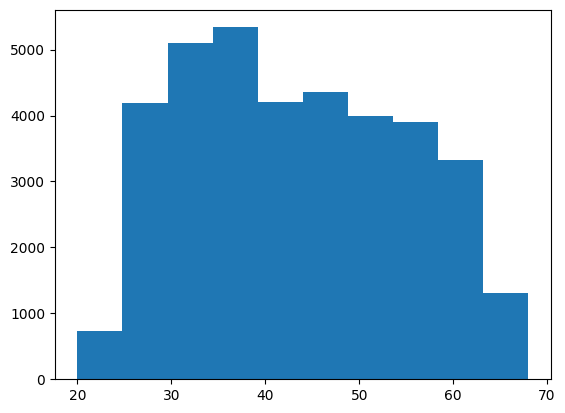

In [50]:
plt.hist(df['age'])

In [51]:
df['age'].describe()

count    36457.000000
mean        43.260334
std         11.510414
min         20.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: age, dtype: float64

## child_num, family_size  확인

In [52]:
np.unique(df['family_size'] - df['child_num'])

array([-1.,  0.,  1.,  2.])

In [53]:
df.groupby(df['family_size'] - df['child_num']).count()['index']

-1.0        2
 0.0        6
 1.0     8435
 2.0    28014
Name: index, dtype: int64

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00, 0.0000e+00,
        0.0000e+00, 8.4350e+03, 0.0000e+00, 0.0000e+00, 2.8014e+04]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

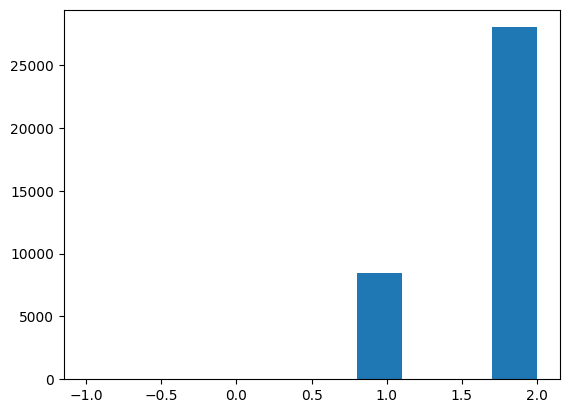

In [54]:
plt.hist(df['family_size'] - df['child_num'])

(array([ 341., 1164.,  771.,  980.,  726.,  897., 1039.,  957., 1078.,
         482.]),
 array([20. , 24.8, 29.6, 34.4, 39.2, 44. , 48.8, 53.6, 58.4, 63.2, 68. ]),
 <BarContainer object of 10 artists>)

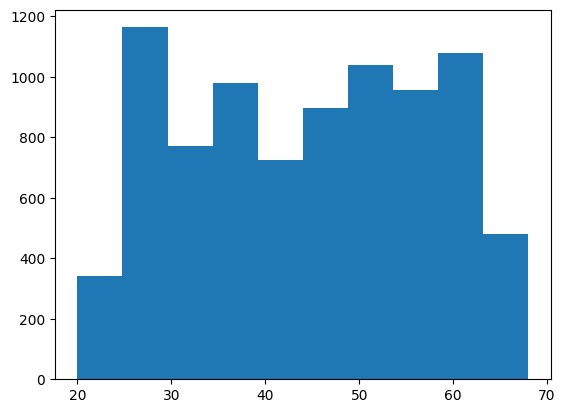

In [55]:
plt.hist(df[df['family_size'] - df['child_num'] == 1.0]['age'])

In [56]:
#df[df['child_num']==0].groupby('family_type').count()['index']

KeyError: 'family_type'

In [ ]:
df[df['family_size'] - df['child_num'] == 1.0].groupby('family_type').count()['index']

In [ ]:
df[df['family_size'] - df['child_num'] == 2.0].groupby('family_type').count()['index']

## FLAG_MOBIL, index 삭제

In [57]:
df.drop(['index','FLAG_MOBIL'], axis=1, inplace=True)

## income_total 로그 변환

In [58]:
df['log_income_total'] = np.log1p(df['income_total'])
df.drop(['income_total'], axis=1, inplace=True)

# 고용되지 않은 사람들 (DAYS_EMPLOYED 가 양수)

## 고용여부 칼럼 생성

In [59]:
df['employed'] = (df['DAYS_EMPLOYED'] < 0).astype(int)

In [60]:
df[df['DAYS_EMPLOYED'] < 0][['DAYS_EMPLOYED', 'employed']].head()

,DAYS_EMPLOYED,employed
0,-4709,1
1,-1540,1
2,-4434,1
3,-2092,1
4,-2105,1


In [61]:
df[df['DAYS_EMPLOYED'] > 0][['DAYS_EMPLOYED', 'employed']].head()

,DAYS_EMPLOYED,employed
14,365243,0
18,365243,0
21,365243,0
24,365243,0
46,365243,0


## 고용 안 된 사람들 DAYS_EMPLOYED 0으로 지정해줌

In [62]:
np.unique(df[df['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'])

array([365243])

In [63]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243,0)

In [64]:
df[df['DAYS_EMPLOYED']==0].shape

(6135, 29)

## DAYS_EMPLOYED - abs()

In [65]:
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()

### transformation



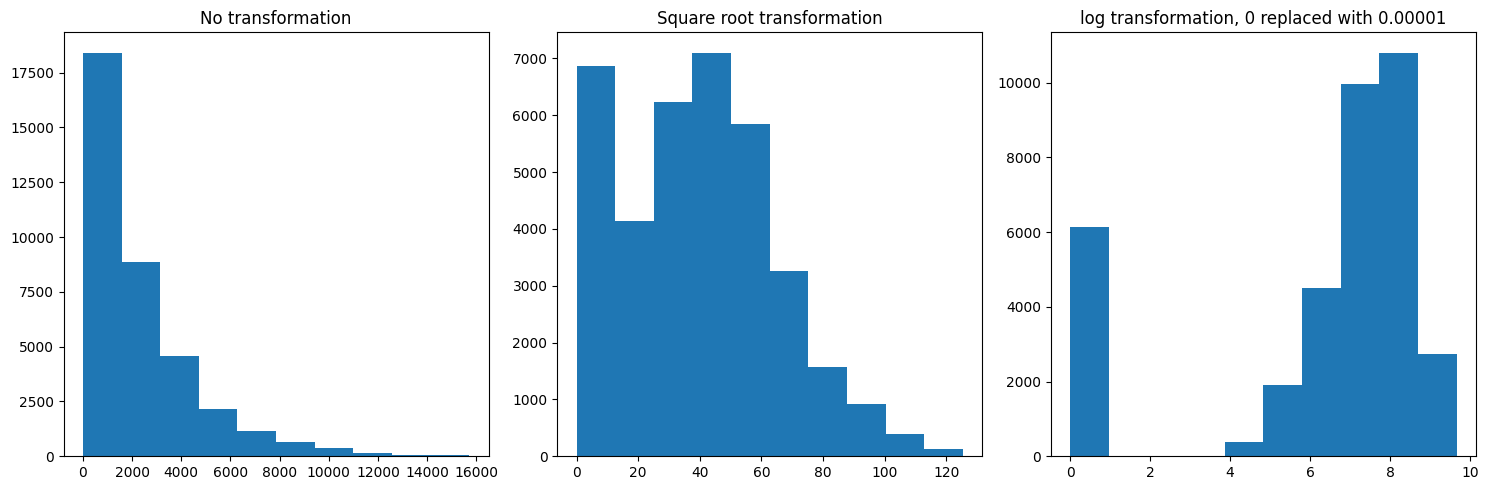

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed

# Plot each set of data on a separate subplot
axes[0].hist(df['DAYS_EMPLOYED'])
axes[0].set_title('No transformation')

axes[1].hist(np.sqrt(df['DAYS_EMPLOYED']))
axes[1].set_title('Square root transformation')

axes[2].hist(np.log1p(df['DAYS_EMPLOYED'].replace(0,0.00001)))
axes[2].set_title('log transformation, 0 replaced with 0.00001')

# Adjust layout
plt.tight_layout()



> A better way to analyze and interpret bimodal distributions is to simply break the data into two separate groups, then analyze the location of the center and the spread for each group individually.
https://www.statology.org/multimodal-distribution/



## dataset 나누고 따로 학습

### employed

In [67]:
df_emp = df[df['DAYS_EMPLOYED']!=0].copy()
df_emp.shape

(30322, 29)

### unemployed

In [68]:
df_unemp = df[df['DAYS_EMPLOYED']==0].copy()
df_unemp.shape

(6135, 29)

In [69]:
df_unemp.groupby('income_type').count()

,gender,car,reality,child_num,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,...,house_type_With parents,family_type_Civil marriage,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,edu_type_encoded,age,log_income_total,employed
income_type,,,,,,,,,,,,,,,,,,,,,
Pensioner,6135,6135,6135,6135,6135,6135,6135,6135,6135,0,...,6135,6135,6135,6135,6135,6135,6135,6135,6135,6135


In [70]:
np.unique(df_unemp['income_type'])
# all the unemployed people are pensioners

array(['Pensioner'], dtype=object)

In [71]:
df_unemp.info()
# occyp_type is all null

<class 'pandas.core.frame.DataFrame'>
Index: 6135 entries, 14 to 36451
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   gender                            6135 non-null   int64  
 1   car                               6135 non-null   int64  
 2   reality                           6135 non-null   int64  
 3   child_num                         6135 non-null   int64  
 4   income_type                       6135 non-null   object 
 5   DAYS_BIRTH                        6135 non-null   int64  
 6   DAYS_EMPLOYED                     6135 non-null   int64  
 7   work_phone                        6135 non-null   int64  
 8   phone                             6135 non-null   int64  
 9   email                             6135 non-null   int64  
 10  occyp_type                        0 non-null      object 
 11  family_size                       6135 non-null   float64
 12  begin_mon

In [72]:
np.unique(df_emp['income_type'])
# there are some pensioners among employed people
# so unemployed people are all pensioners but not all pensioners are unemployed (some are currently employed)

array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
       'Working'], dtype=object)

In [73]:
df_emp.groupby('income_type').count()
# 17 pensioners

,gender,car,reality,child_num,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,...,house_type_With parents,family_type_Civil marriage,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,edu_type_encoded,age,log_income_total,employed
income_type,,,,,,,,,,,,,,,,,,,,,
Commercial associate,8490,8490,8490,8490,8490,8490,8490,8490,8490,7052,...,8490,8490,8490,8490,8490,8490,8490,8490,8490,8490
Pensioner,17,17,17,17,17,17,17,17,17,13,...,17,17,17,17,17,17,17,17,17,17
State servant,2985,2985,2985,2985,2985,2985,2985,2985,2985,2437,...,2985,2985,2985,2985,2985,2985,2985,2985,2985,2985
Student,11,11,11,11,11,11,11,11,11,10,...,11,11,11,11,11,11,11,11,11,11
Working,18819,18819,18819,18819,18819,18819,18819,18819,18819,15622,...,18819,18819,18819,18819,18819,18819,18819,18819,18819,18819


Text(0.5, 1.0, 'Age of unemployed people')

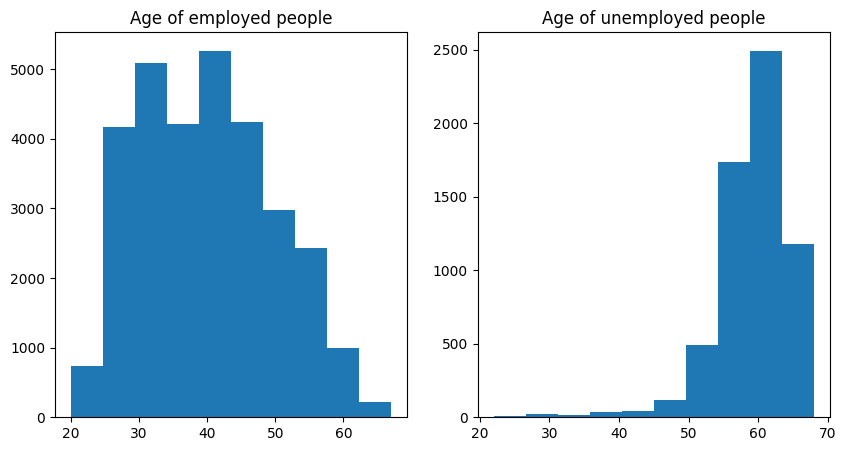

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot each set of data on a separate subplot
axes[0].hist(df_emp['age'])
axes[0].set_title('Age of employed people')

axes[1].hist(df_unemp['age'])
axes[1].set_title('Age of unemployed people')

In [75]:
df_emp['age'].describe()

count    30322.000000
mean        40.049304
std          9.609305
min         20.000000
25%         32.000000
50%         39.000000
75%         47.000000
max         67.000000
Name: age, dtype: float64

In [76]:
df_unemp['age'].describe()

count    6135.000000
mean       59.130725
std         5.301155
min        22.000000
25%        57.000000
50%        60.000000
75%        63.000000
max        68.000000
Name: age, dtype: float64

df_unemp 에 필요없는 칼럼 삭제 (모두 같음)

In [77]:
df_unemp.drop(['DAYS_EMPLOYED','income_type', 'occyp_type','employed', 'DAYS_BIRTH'], axis=1, inplace = True)

## df_emp

### employed_age 생성

In [78]:
df_emp['employed_age'] = (df_emp['DAYS_BIRTH'] - df_emp['DAYS_EMPLOYED'])//365

In [79]:
df_emp['employed_age'].describe()

count    30322.000000
mean        32.804136
std          9.577214
min         17.000000
25%         25.000000
50%         31.000000
75%         40.000000
max         65.000000
Name: employed_age, dtype: float64

In [80]:
df_emp.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'employed'], axis=1, inplace=True)

In [81]:
df_emp.groupby('family_size').count()

,gender,car,reality,child_num,income_type,work_phone,phone,email,occyp_type,begin_month,...,house_type_With parents,family_type_Civil marriage,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,edu_type_encoded,age,log_income_total,employed_age
family_size,,,,,,,,,,,,,,,,,,,,,
1.0,5151,5151,5151,5151,5151,5151,5151,5151,4263,5151,...,5151,5151,5151,5151,5151,5151,5151,5151,5151,5151
2.0,15389,15389,15389,15389,15389,15389,15389,15389,12697,15389,...,15389,15389,15389,15389,15389,15389,15389,15389,15389,15389
3.0,6255,6255,6255,6255,6255,6255,6255,6255,5216,6255,...,6255,6255,6255,6255,6255,6255,6255,6255,6255,6255
4.0,3057,3057,3057,3057,3057,3057,3057,3057,2576,3057,...,3057,3057,3057,3057,3057,3057,3057,3057,3057,3057
5.0,387,387,387,387,387,387,387,387,307,387,...,387,387,387,387,387,387,387,387,387,387
6.0,58,58,58,58,58,58,58,58,51,58,...,58,58,58,58,58,58,58,58,58,58
7.0,19,19,19,19,19,19,19,19,18,19,...,19,19,19,19,19,19,19,19,19,19
9.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
15.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [82]:
df_unemp.groupby('family_size').count()

,gender,car,reality,child_num,work_phone,phone,email,begin_month,credit,house_type_Co-op apartment,...,house_type_Rented apartment,house_type_With parents,family_type_Civil marriage,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,edu_type_encoded,age,log_income_total
family_size,,,,,,,,,,,,,,,,,,,,,
1.0,1836,1836,1836,1836,1836,1836,1836,1836,1358,1836,...,1836,1836,1836,1836,1836,1836,1836,1836,1836,1836
2.0,4074,4074,4074,4074,4074,4074,4074,4074,2924,4074,...,4074,4074,4074,4074,4074,4074,4074,4074,4074,4074
3.0,166,166,166,166,166,166,166,166,117,166,...,166,166,166,166,166,166,166,166,166,166
4.0,49,49,49,49,49,49,49,49,30,49,...,49,49,49,49,49,49,49,49,49,49
5.0,10,10,10,10,10,10,10,10,9,10,...,10,10,10,10,10,10,10,10,10,10


### income_type, occyp_type get_dummies

In [83]:
df_emp = pd.get_dummies(df_emp,
                    columns = ['income_type', 'occyp_type'],
                    prefix = ['income_type', 'occyp_type'])

# 이전 코드 (왜 한번에 income_total log normalization 했는지)

Text(0.5, 1.0, 'log income_total of unemployed people')

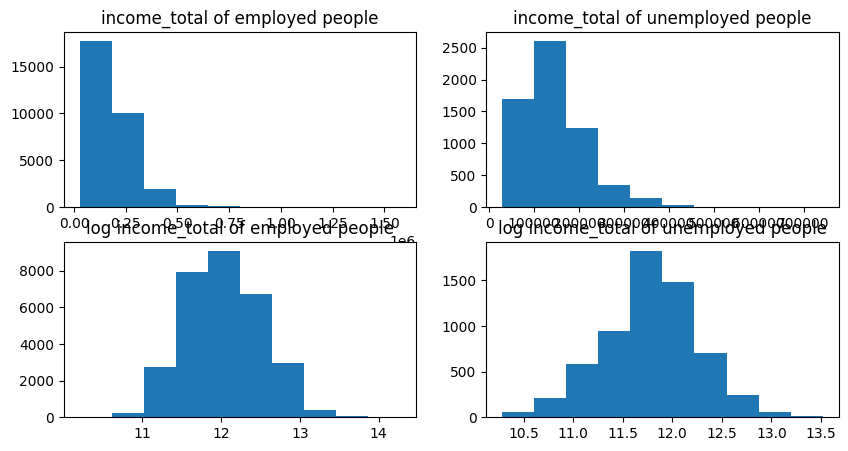

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plot each set of data on a separate subplot
axes[0,0].hist(df_emp['income_total'])
axes[0,0].set_title('income_total of employed people')

axes[0,1].hist(df_unemp['income_total'])
axes[0,1].set_title('income_total of unemployed people')

axes[1,0].hist(np.log1p(df_emp['income_total']))
axes[1,0].set_title('log income_total of employed people')

axes[1,1].hist(np.log1p(df_unemp['income_total']))
axes[1,1].set_title('log income_total of unemployed people')

# 일단 여기까지 df export

In [ ]:
print(df_emp.select_dtypes("object").columns)
print(df_unemp.select_dtypes("object").columns)

Index([], dtype='object')
Index([], dtype='object')


In [ ]:
df_unemp.to_csv('df_unemp.csv', index=True)
df_emp.to_csv('df_emp.csv', index=True)

# Data preprocessing

In [19]:
#df_unemp = pd.read_csv('/content/df_unemp.csv')
#df_emp = pd.read_csv('/content/df_emp.csv')

In [84]:
unemp_test = df_unemp[df_unemp['credit'].isnull()].copy()
unemp_train = df_unemp[df_unemp['credit'].notnull()].copy()

In [85]:
emp_test = df_emp[df_emp['credit'].isnull()].copy()
emp_train = df_emp[df_emp['credit'].notnull()].copy()

In [ ]:
test.shape

(10000, 19)

In [86]:
print(unemp_test.shape)
print(emp_test.shape)

(1697, 24)
(8303, 48)


In [87]:
# test dfs: drop credit
emp_test.drop(['credit'], axis=1, inplace=True)
unemp_test.drop(['credit'], axis=1, inplace=True)

In [88]:
# train dfs: label encode credit
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
emp_train['credit']=le.fit_transform(emp_train['credit'])
unemp_train['credit']=le.fit_transform(unemp_train['credit'])

In [89]:
# split dfs into X and Y
emp_X = emp_train.drop('credit', axis=1, inplace=False)
emp_Y = emp_train['credit']
unemp_X = unemp_train.drop('credit', axis=1, inplace=False)
unemp_Y = unemp_train['credit']

In [ ]:
df_unemp.to_csv('df_unemp.csv', index=False)
df_emp.to_csv('df_emp.csv', index=False)
emp_train.to_csv('emp_train.csv', index=False)
unemp_train.to_csv('unemp_train.csv', index=False)
emp_X.to_csv('emp_X.csv', index=False)
emp_Y.to_csv('emp_Y.csv', index=False)
unemp_X.to_csv('unemp_X.csv', index=False)
unemp_Y.to_csv('unemp_Y.csv', index=False)

# Reload df

In [12]:
emp_train = pd.read_csv('/content/emp_train.csv')
unemp_train = pd.read_csv('/content/unemp_train.csv')
emp_X = pd.read_csv('/content/emp_X.csv')
emp_Y = pd.read_csv('/content/emp_Y.csv')
unemp_X = pd.read_csv('/content/unemp_X.csv')
unemp_Y = pd.read_csv('/content/unemp_Y.csv')

In [16]:
emp_Y = emp_Y['credit']
unemp_Y = unemp_Y['credit']

# Train Test split

In [ ]:
from sklearn.model_selection import train_test_split
emp_X_train, emp_X_test, emp_y_train, emp_y_test = train_test_split(emp_X, emp_Y,
                                                                    shuffle = True, test_size = 0.2, random_state=1)
unemp_X_train, unemp_X_test, unemp_y_train, unemp_y_test = train_test_split(unemp_X, unemp_Y,
                                                                    shuffle = True, test_size = 0.2, random_state=1)

# Various Models Evaluation (with emp)

## fit

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
emp_dtc = DecisionTreeClassifier(criterion = "gini", random_state=1)
emp_dtc.fit(emp_X_train, emp_y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
emp_gb = GradientBoostingClassifier(learning_rate = 0.1, random_state=1)
emp_gb.fit(emp_X_train, emp_y_train)

GradientBoostingClassifier(random_state=1)

In [ ]:
# XGBoost
from xgboost import XGBClassifier
emp_xgb_model = XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          random_state=1)
emp_xgb_model.fit(emp_X_train, emp_y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Bagging
from sklearn.ensemble import BaggingClassifier
emp_dtbag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 500,
                          max_samples = 100, bootstrap = True,
                          random_state = 1)
emp_dtbag.fit(emp_X_train, emp_y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, random_state=1)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
emp_rf = RandomForestClassifier(random_state=1)
emp_rf.fit(emp_X_train, emp_y_train)

RandomForestClassifier(random_state=1)

## evaluate model

In [ ]:
# function evaluating accuracy
def evaluate_model(model, x_test, y_test):
  from sklearn import metrics
  import pandas as pd
  # Predict test data
  y_pred = model.predict(x_test)
  y_predproba = model.predict_proba(x_test)
  # calculate accuracy
  acc = metrics.accuracy_score(y_test, y_pred)
  # log loss
  from sklearn.metrics import log_loss
  loss = log_loss(y_test, y_predproba)
  return acc, loss

# function printing result
def return_fun(mymodel, X_test, y_test):
  print("============================")
  print(f'{mymodel} 결과')
  print("============================")
  print(f' accuracy')
  print(f'{evaluate_model(mymodel, X_test, y_test)[0]}')
  print(f' log loss')
  print(f'{evaluate_model(mymodel, X_test, y_test)[1]}')
  print('\n')

In [ ]:
# Decision Tree
return_fun(emp_dtc, emp_X_test, emp_y_test)
# Gradient Boosting
return_fun(emp_gb, emp_X_test, emp_y_test)
# XGBoost
return_fun(emp_xgb_model, emp_X_test, emp_y_test)
# Bagging
return_fun(emp_dtbag, emp_X_test, emp_y_test)
# Random Forest
return_fun(emp_rf, emp_X_test, emp_y_test)

DecisionTreeClassifier(random_state=1) 결과
 accuracy
0.6192098092643051
 log loss
13.18553854441947


GradientBoostingClassifier(random_state=1) 결과
 accuracy
0.6950499545867393
 log loss
0.7869243361922598


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...) 결과
 accuracy
0.71230

XGB performed best, then GB

# XGB no tuning

## fit

In [ ]:
# XGBoost
from xgboost import XGBClassifier
unemp_xgb = XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          random_state=1)
unemp_xgb.fit(unemp_X, unemp_Y)
unemp_xgb_pred = unemp_xgb.predict_proba(unemp_test)

emp_xgb = XGBClassifier(objective='multi:softprob',
                          eval_metric='mlogloss',
                          random_state=1)
emp_xgb.fit(emp_X, emp_Y)
emp_xgb_pred = emp_xgb.predict_proba(emp_test)

In [ ]:
unemp_xgb_pred

array([[0.01215109, 0.01271682, 0.9751321 ],
       [0.05477696, 0.04965175, 0.89557135],
       [0.03690228, 0.17034316, 0.79275453],
       ...,
       [0.17371914, 0.06448361, 0.76179725],
       [0.25352493, 0.1992245 , 0.54725057],
       [0.03753685, 0.9614036 , 0.00105954]], dtype=float32)

In [ ]:
unemp_xgb_preddf = pd.DataFrame(unemp_xgb_pred, columns=['0', '1', '2'])
unemp_xgb_preddf.head()

,0,1,2
0,0.012151,0.012717,0.975132
1,0.054777,0.049652,0.895571
2,0.036902,0.170343,0.792755
3,0.068181,0.064328,0.867491
4,0.045291,0.158406,0.796303


In [ ]:
unemp_xgb_preddf['index'] = unemp_test.index
unemp_xgb_preddf.head()

,0,1,2,index
0,0.012151,0.012717,0.975132,26457
1,0.054777,0.049652,0.895571,26464
2,0.036902,0.170343,0.792755,26467
3,0.068181,0.064328,0.867491,26470
4,0.045291,0.158406,0.796303,26471


In [ ]:
emp_xgb_preddf = pd.DataFrame(emp_xgb_pred, columns=['0', '1', '2'])
emp_xgb_preddf['index'] = emp_test.index
emp_xgb_preddf.head()

,0,1,2,index
0,0.171485,0.111444,0.717071,26458
1,0.117684,0.152829,0.729487,26459
2,0.125648,0.110392,0.763959,26460
3,0.104066,0.217485,0.678450,26461
4,0.042884,0.196652,0.760464,26462


In [ ]:
# Concatenate the two dataframes along the index column
concat_pred = pd.concat([emp_xgb_preddf, unemp_xgb_preddf], ignore_index=True)
# Sort the concatenated dataframe based on the index column
concat_sub = concat_pred.sort_values(by='index', inplace=False)
concat_sub.head(20)

,0,1,2,index
8303,0.012151,0.012717,0.975132,26457
0,0.171485,0.111444,0.717071,26458
1,0.117684,0.152829,0.729487,26459
2,0.125648,0.110392,0.763959,26460
3,0.104066,0.217485,0.678450,26461
4,0.042884,0.196652,0.760464,26462
5,0.656570,0.342560,0.000871,26463
8304,0.054777,0.049652,0.895571,26464
6,0.051735,0.100242,0.848023,26465
7,0.078919,0.184070,0.737011,26466


In [ ]:
new_column_order = ['index', '0', '1', '2']
concat_sub2 = concat_sub[new_column_order]
# Reset the index of the resulting dataframe
concat_sub2.reset_index(drop=True, inplace=True)
concat_sub2.head(20)

,index,0,1,2
0,26457,0.012151,0.012717,0.975132
1,26458,0.171485,0.111444,0.717071
2,26459,0.117684,0.152829,0.729487
3,26460,0.125648,0.110392,0.763959
4,26461,0.104066,0.217485,0.678450
5,26462,0.042884,0.196652,0.760464
6,26463,0.656570,0.342560,0.000871
7,26464,0.054777,0.049652,0.895571
8,26465,0.051735,0.100242,0.848023
9,26466,0.078919,0.184070,0.737011


In [ ]:
concat_sub2.to_csv('sub3.csv', index=False)

데이콘 점수:\
public: 0.7667474714\
private: 0.7371697807

# XGB GridSearchCV

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(objective = 'multi:softprob', num_class = 3, verbose = -1,
                    early_stopping_rounds=5, random_state=1)

params = {'learning_rate':[0.05 ,0.1],
          'n_estimators':[200,300,400],
          'max_depth':[None,4,6,10,12],
          'min_child_weight':[1,3,5,10],
          'subsample':[0.8,0.9]}

In [ ]:
xgb_gridcv = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=3,
                      n_jobs=-1,
                      scoring='neg_log_loss')

xgb_gridcv.fit(emp_X_train, emp_y_train,
               eval_metric="mlogloss",
               eval_set=[(emp_X_train, emp_y_train), (emp_X_test, emp_y_test)])

Fitting 3 folds for each of 240 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.07118	validation_1-mlogloss:1.07434
[1]	validation_0-mlogloss:1.04587	validation_1-mlogloss:1.05253
[2]	validation_0-mlogloss:1.02140	validation_1-mlogloss:1.03179
[3]	validation_0-mlogloss:0.99916	validation_1-mlogloss:1.01302


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:32:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-mlogloss:0.97820	validation_1-mlogloss:0.99540
[5]	validation_0-mlogloss:0.95840	validation_1-mlogloss:0.97916
[6]	validation_0-mlogloss:0.93974	validation_1-mlogloss:0.96416
[7]	validation_0-mlogloss:0.92164	validation_1-mlogloss:0.94986
[8]	validation_0-mlogloss:0.90541	validation_1-mlogloss:0.93686
[9]	validation_0-mlogloss:0.88984	validation_1-mlogloss:0.92471
[10]	validation_0-mlogloss:0.87569	validation_1-mlogloss:0.91349
[11]	validation_0-mlogloss:0.86187	validation_1-mlogloss:0.90248
[12]	validation_0-mlogloss:0.84937	validation_1-mlogloss:0.89282
[13]	validation_0-mlogloss:0.83553	validation_1-mlogloss:0.88291
[14]	validation_0-mlogloss:0.82408	validation_1-mlogloss:0.87434
[15]	validation_0-mlogloss:0.81331	validation_1-mlogloss:0.86642
[16]	validation_0-mlogloss:0.80174	validation_1-mlogloss:0.85853
[17]	validation_0-mlogloss:0.79167	validation_1-mlogloss:0.85129
[18]	validation_0-mlogloss:0.78135	validation_1-mlogloss:0.84440
[19]	validation_0-mlogloss:0.77

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=5,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [None, 4, 6, 10, 12],
                         'min_child_weight': [1, 3, 5, 10],
                         'n_estimators': [200, 300, 400],
                         'subsample': [0.8, 0.9]},
             scoring='neg_log_loss', verbose=1)

In [ ]:
emp_xgb_bestparams = xgb_gridcv.best_params_
print("Best parameters:", emp_xgb_bestparams)
print("Best Negative Log Loss Score:", xgb_gridcv.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best Negative Log Loss Score: -0.758816940353859


In [ ]:
emp_xgb = XGBClassifier(**emp_xgb_bestparams)
emp_xgb.fit(emp_X, emp_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
unemp_xgb_gridcv = GridSearchCV(estimator=xgb,
                      param_grid=params,
                      cv=3,
                      n_jobs=-1,
                      scoring='neg_log_loss')
unemp_xgb_gridcv.fit(unemp_X_train, unemp_y_train,
               eval_metric="mlogloss",
               eval_set=[(unemp_X_train, unemp_y_train), (unemp_X_test, unemp_y_test)])
unemp_xgb_bestparams = unemp_xgb_gridcv.best_params_
print("Best parameters:", unemp_xgb_bestparams)
print("Best Negative Log Loss Score:", unemp_xgb_gridcv.best_score_)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[0]	validation_0-mlogloss:1.03985	validation_1-mlogloss:1.05251
[1]	validation_0-mlogloss:0.98943	validation_1-mlogloss:1.01235
[2]	validation_0-mlogloss:0.94737	validation_1-mlogloss:0.97979
[3]	validation_0-mlogloss:0.90989	validation_1-mlogloss:0.95206
[4]	validation_0-mlogloss:0.87674	validation_1-mlogloss:0.92960
[5]	validation_0-mlogloss:0.84602	validation_1-mlogloss:0.90697
[6]	validation_0-mlogloss:0.81812	validation_1-mlogloss:0.88949
[7]	validation_0-mlogloss:0.79521	validation_1-mlogloss:0.87409
[8]	validation_0-mlogloss:0.77048	validation_1-mlogloss:0.86007
[9]	validation_0-mlogloss:0.75163	validation_1-mlogloss:0.84833
[10]	validation_0-mlogloss:0.73250	validation_1-mlogloss:0.83703
[11]	validation_0-mlogloss:0.71531	validation_1-mlogloss:0.82688
[12]	validation_0-mlogloss:0.70086	validation_1-mlogloss:0.81930
[13]	validation_0-mlogloss:0.68442	validation_1-mlogloss:0.81330


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:49:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-mlogloss:0.67427	validation_1-mlogloss:0.80745
[15]	validation_0-mlogloss:0.66214	validation_1-mlogloss:0.80224
[16]	validation_0-mlogloss:0.64823	validation_1-mlogloss:0.79577
[17]	validation_0-mlogloss:0.63866	validation_1-mlogloss:0.79210
[18]	validation_0-mlogloss:0.62574	validation_1-mlogloss:0.78862
[19]	validation_0-mlogloss:0.61561	validation_1-mlogloss:0.78403
[20]	validation_0-mlogloss:0.60643	validation_1-mlogloss:0.78147
[21]	validation_0-mlogloss:0.59585	validation_1-mlogloss:0.77830
[22]	validation_0-mlogloss:0.58675	validation_1-mlogloss:0.77669
[23]	validation_0-mlogloss:0.57993	validation_1-mlogloss:0.77565
[24]	validation_0-mlogloss:0.57170	validation_1-mlogloss:0.77410
[25]	validation_0-mlogloss:0.56344	validation_1-mlogloss:0.77380
[26]	validation_0-mlogloss:0.55778	validation_1-mlogloss:0.77327
[27]	validation_0-mlogloss:0.55003	validation_1-mlogloss:0.77034
[28]	validation_0-mlogloss:0.54129	validation_1-mlogloss:0.76910
[29]	validation_0-mloglos

In [ ]:
unemp_xgb = XGBClassifier(**unemp_xgb_bestparams)
unemp_xgb.fit(unemp_X, unemp_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# LGBM Optuna

In [8]:
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
def objective_lgbm_(trial):

    # Hyperparameters to be tuned
    params = {
              'objective': 'multiclass',
              'num_class': 3,
              'max_depth': trial.suggest_int('max_depth',1,10),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
              'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
              'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
              'subsample': trial.suggest_float('subsample', 0.8, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.2),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.8, 1.0),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 1.0),
              'num_leaves': trial.suggest_int('num_leaves', 10, 100),
              'random_state': 1
            }


    model = LGBMClassifier(**params, verbose=-1)

    scores = cross_val_score(model, unemp_X, unemp_Y, cv=5, scoring='neg_log_loss')

    return -scores.mean()

# Optuna optimization
unemp_lgbm_study = optuna.create_study(direction='minimize')
unemp_lgbm_study.optimize(objective_lgbm, n_trials=100)
# Adjust the number of trials to 100-1000

# Best hyperparameters
unemp_best_params = unemp_lgbm_study.best_params
print('Best Parameters:', unemp_best_params)

[I 2024-04-05 12:13:10,501] A new study created in memory with name: no-name-00f4d4e7-0c58-43fa-8c2b-a781c56cca1d
[I 2024-04-05 12:13:13,463] Trial 0 finished with value: 0.7861043289332932 and parameters: {'max_depth': 7, 'min_child_samples': 31, 'learning_rate': 0.05361547052542498, 'n_estimators': 249, 'min_child_weight': 5, 'subsample': 0.9285729133657481, 'colsample_bytree': 0.1666922234414857, 'reg_alpha': 0.9577854467560081, 'reg_lambda': 0.8672601368287235, 'num_leaves': 100}. Best is trial 0 with value: 0.7861043289332932.
[I 2024-04-05 12:13:17,751] Trial 1 finished with value: 0.7920612638036906 and parameters: {'max_depth': 4, 'min_child_samples': 19, 'learning_rate': 0.04309668505454437, 'n_estimators': 631, 'min_child_weight': 10, 'subsample': 0.961265891854697, 'colsample_bytree': 0.16885184493776323, 'reg_alpha': 0.8389412964107026, 'reg_lambda': 0.8690916840270492, 'num_leaves': 76}. Best is trial 0 with value: 0.7861043289332932.
[I 2024-04-05 12:13:21,405] Trial 2 fi

Best Parameters: {'max_depth': 10, 'min_child_samples': 26, 'learning_rate': 0.06981885841164913, 'n_estimators': 999, 'min_child_weight': 3, 'subsample': 0.9451501627452686, 'colsample_bytree': 0.1947788164543793, 'reg_alpha': 0.8678543706847648, 'reg_lambda': 0.9177348070969059, 'num_leaves': 55}


In [13]:
unemp_best_params = {'max_depth': 10, 'min_child_samples': 26, 'learning_rate': 0.06981885841164913, 'n_estimators': 999, 'min_child_weight': 3, 'subsample': 0.9451501627452686, 'colsample_bytree': 0.1947788164543793, 'reg_alpha': 0.8678543706847648, 'reg_lambda': 0.9177348070969059, 'num_leaves': 55}
from lightgbm import LGBMClassifier
unemp_lgbm_optuna = LGBMClassifier(**unemp_best_params, verbose=-1)
unemp_lgbm_optuna.fit(unemp_X, unemp_Y)
#unemp_lgbm_optuna_pred = unemp_lgbm_optuna.predict_proba(unemp_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier(colsample_bytree=0.1947788164543793,
               learning_rate=0.06981885841164913, max_depth=10,
               min_child_samples=26, min_child_weight=3, n_estimators=999,
               num_leaves=55, reg_alpha=0.8678543706847648,
               reg_lambda=0.9177348070969059, subsample=0.9451501627452686,
               verbose=-1)

feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

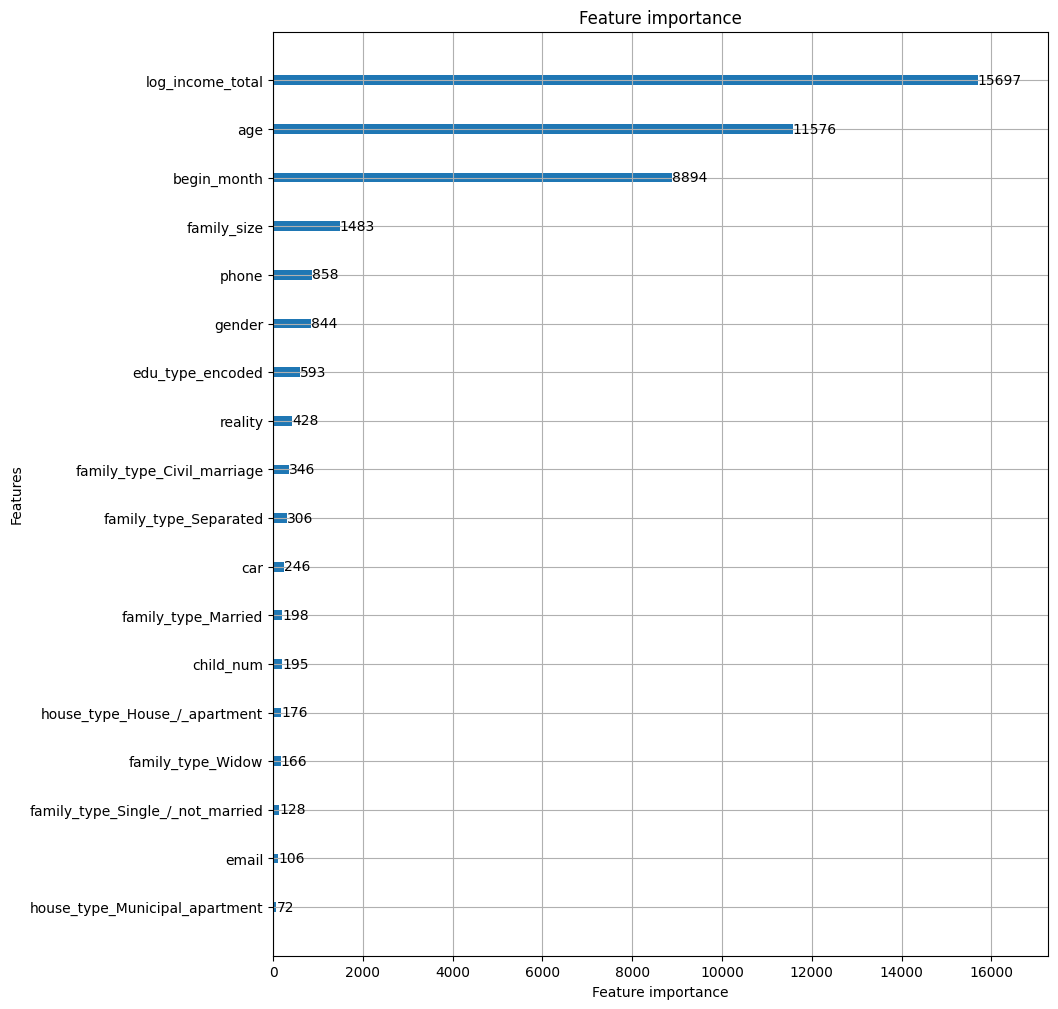

In [ ]:
from lightgbm import plot_importance
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(unemp_lgbm_optuna, ax=ax)

In [17]:
def objective_lgbm(trial):

    # Hyperparameters to be tuned
    params = {
              'objective': 'multiclass',
              'num_class': 3,
              'max_depth': trial.suggest_int('max_depth',1,10),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
              'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
              'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
              'subsample': trial.suggest_float('subsample', 0.8, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.2),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.8, 1.0),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.8, 1.0),
              'num_leaves': trial.suggest_int('num_leaves', 10, 100),
              'random_state': 1
            }


    model = LGBMClassifier(**params, verbose=-1)

    scores = cross_val_score(model, emp_X, emp_Y, cv=5, scoring='neg_log_loss')

    return -scores.mean()
# Optuna optimization
emp_lgm_study = optuna.create_study(direction='minimize')
emp_lgm_study.optimize(objective_lgbm, n_trials=100)
# Adjust the number of trials to 100-1000

# Best hyperparameters
emp_best_params = emp_lgm_study.best_params
print('Best Parameters:', emp_best_params)

[I 2024-04-08 02:42:05,932] A new study created in memory with name: no-name-82fb5559-355f-4f36-9e9b-cafb3bf88f21
[I 2024-04-08 02:42:23,957] Trial 0 finished with value: 0.7802396720959374 and parameters: {'max_depth': 5, 'min_child_samples': 42, 'learning_rate': 0.09137516377973659, 'n_estimators': 724, 'min_child_weight': 8, 'subsample': 0.9863755338874103, 'colsample_bytree': 0.10899726206949019, 'reg_alpha': 0.8529822893285806, 'reg_lambda': 0.910983697918967, 'num_leaves': 71}. Best is trial 0 with value: 0.7802396720959374.
[I 2024-04-08 02:42:30,001] Trial 1 finished with value: 0.8109452858275746 and parameters: {'max_depth': 7, 'min_child_samples': 22, 'learning_rate': 0.05667257572061431, 'n_estimators': 245, 'min_child_weight': 2, 'subsample': 0.8035647445292036, 'colsample_bytree': 0.13222692626600924, 'reg_alpha': 0.8625640968677981, 'reg_lambda': 0.9166555070244116, 'num_leaves': 10}. Best is trial 0 with value: 0.7802396720959374.
[I 2024-04-08 02:42:50,872] Trial 2 fin

Best Parameters: {'max_depth': 10, 'min_child_samples': 28, 'learning_rate': 0.08608535151295783, 'n_estimators': 925, 'min_child_weight': 2, 'subsample': 0.9489512628231067, 'colsample_bytree': 0.1885029509772711, 'reg_alpha': 0.800289915419545, 'reg_lambda': 0.9665565957693152, 'num_leaves': 57}


In [22]:
emp_lgbm_optuna = LGBMClassifier(**emp_best_params, verbose=-1)
emp_lgbm_optuna.fit(emp_X, emp_Y)
#emp_lgbm_optuna_pred = emp_lgbm_optuna.predict_proba(emp_test)

LGBMClassifier(colsample_bytree=0.1885029509772711,
               learning_rate=0.08608535151295783, max_depth=10,
               min_child_samples=28, min_child_weight=2, n_estimators=925,
               num_leaves=57, reg_alpha=0.800289915419545,
               reg_lambda=0.9665565957693152, subsample=0.9489512628231067,
               verbose=-1)

## submission processing

In [ ]:
unemp_lgbm_optuna_pred = unemp_lgbm_optuna.predict_proba(unemp_test)

In [ ]:
# unemp
unemp_index = pd.DataFrame(unemp_test.index, columns=['index'])
unemp_pred_df = pd.DataFrame(unemp_lgbm_optuna_pred, columns=['0', '1', '2'])
unemp_lgbm_optuna_pred = pd.concat([unemp_index, unemp_pred_df], axis=1)
unemp_lgbm_optuna_pred.head(2)

In [ ]:
# emp
emp_index = pd.DataFrame(emp_test.index, columns=['index'])
emp_pred_df = pd.DataFrame(emp_lgbm_optuna_pred, columns=['0', '1', '2'])
emp_lgbm_optuna_pred = pd.concat([emp_index, emp_pred_df], axis=1)
emp_lgbm_optuna_pred.head(2)

combine

In [ ]:
# Concatenate the two dataframes along the index column
lgbm_tuned_combine = pd.concat([unemp_lgbm_optuna_pred, emp_lgbm_optuna_pred], ignore_index=True)
# Sort the concatenated dataframe based on the index column
lgbm_tuned_sub = lgbm_tuned_combine.sort_values(by='index', inplace=False)
# reset index
lgbm_tuned_sub.reset_index(drop=True, inplace=True)
lgbm_tuned_sub.head()

,index,0,1,2
0,26457,0.038033,0.076395,0.885573
1,26458,0.234532,0.112959,0.652509
2,26459,0.127499,0.194847,0.677654
3,26460,0.118371,0.156388,0.725241
4,26461,0.070144,0.206837,0.723019


In [ ]:
lgbm_tuned_sub.to_csv('lgbm_tuned_sub.csv', index=False)

데이콘 점수:\
public: 0.7642797189\
private: 0.7470438082

# RF GridSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier

params = {'random_state':[1],
          'n_jobs':[-1],
          'n_estimators':[100,300,500],
          'max_depth':[None,3,5,10],
          'min_samples_leaf':[1,2,4],
          'min_samples_split':[2,5,10],
          'max_features':['sqrt', 'log2']}

In [ ]:
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
unemp_rf = RandomForestClassifier(random_state=1, n_jobs=-1)

from sklearn.metrics import make_scorer, log_loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

from sklearn.model_selection import GridSearchCV
unemp_rf_gridcv = GridSearchCV(estimator=unemp_rf,
                      param_grid=params,
                      cv=3,
                      n_jobs=-1,
                      scoring=log_loss_scorer,
                      verbose=1)

unemp_rf_gridcv.fit(unemp_X, unemp_Y)

#unemp_rf_bestparams = unemp_rf_gridcv.best_params_

print("Best parameters:", unemp_rf_bestparams)
print("Best Negative Log Loss Score:", unemp_rf_gridcv.best_score_)

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 1}
Best Negative Log Loss Score: -0.7461077660491693


In [24]:
unemp_rf_bestparams = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 1}


In [27]:
#unemp_rf = unemp_rf_gridcv.best_estimator_
from sklearn.ensemble import RandomForestClassifier
unemp_rf = RandomForestClassifier(**unemp_rf_bestparams)
unemp_rf.fit(unemp_X, unemp_Y)
#unemp_rf_pred = unemp_rf.predict_proba(unemp_test)

RandomForestClassifier(min_samples_leaf=2, n_estimators=500, n_jobs=-1,
                       random_state=1)

In [ ]:
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
emp_rf = RandomForestClassifier(random_state=1, n_jobs=-1)

emp_rf_gridcv = GridSearchCV(estimator=emp_rf,
                      param_grid=params,
                      cv=3,
                      n_jobs=-1,
                      scoring=log_loss_scorer,
                      verbose=1)

emp_rf_gridcv.fit(emp_X, emp_Y)

emp_rf_bestparams = emp_rf_gridcv.best_params_
print("Best parameters:", emp_rf_bestparams)
print("Best Negative Log Loss Score:", emp_rf_gridcv.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 1}
Best Negative Log Loss Score: -0.7194914475448787


In [28]:
emp_rf_bestparams = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 1}
emp_rf = RandomForestClassifier(**emp_rf_bestparams)
#emp_rf = emp_rf_gridcv.best_estimator_
emp_rf.fit(emp_X, emp_Y)
#emp_rf_pred = emp_rf.predict_proba(emp_test)

RandomForestClassifier(min_samples_split=10, n_estimators=500, n_jobs=-1,
                       random_state=1)

# Voting: LGBM (optuna) and RF (gridsearch)

In [29]:
# VotingClassifier
from sklearn.ensemble import VotingClassifier
emp_VT = VotingClassifier(estimators=[('RF', emp_rf), ('LGBM', emp_lgbm_optuna)], voting='soft', n_jobs=-1)
emp_VT.fit(emp_X, emp_Y)
unemp_VT = VotingClassifier(estimators=[('RF', unemp_rf), ('LGBM', unemp_lgbm_optuna)], voting='soft', n_jobs=-1)
unemp_VT.fit(unemp_X, unemp_Y)

VotingClassifier(estimators=[('RF',
                              RandomForestClassifier(min_samples_leaf=2,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=1)),
                             ('LGBM',
                              LGBMClassifier(colsample_bytree=0.1947788164543793,
                                             learning_rate=0.06981885841164913,
                                             max_depth=10, min_child_samples=26,
                                             min_child_weight=3,
                                             n_estimators=999, num_leaves=55,
                                             reg_alpha=0.8678543706847648,
                                             reg_lambda=0.9177348070969059,
                                             subsample=0.9451501627452686,
                                             verbose=-1))],
                 n_jobs=-1, voting='soft')

In [37]:
# predict
emp_VT_pred = emp_VT.predict_proba(emp_test)
unemp_VT_pred = unemp_VT.predict_proba(unemp_test)

## submission processing

In [90]:
# pred df
unemp_index = pd.DataFrame(unemp_test.index, columns=['index'])
emp_index = pd.DataFrame(emp_test.index, columns=['index'])
unemp_pred_df = pd.DataFrame(unemp_VT_pred, columns=['0', '1', '2'])
unemp_VT_pred_df = pd.concat([unemp_index, unemp_pred_df], axis=1)
emp_pred_df = pd.DataFrame(emp_VT_pred, columns=['0', '1', '2'])
emp_VT_pred_df = pd.concat([emp_index, emp_pred_df], axis=1)
# Concatenate the two dataframes along the index column
VT_combine = pd.concat([unemp_VT_pred_df, emp_VT_pred_df], ignore_index=True)
# Sort the concatenated dataframe based on the index column
VT_sub = VT_combine.sort_values(by='index', inplace=False)
# reset index
VT_sub.reset_index(drop=True, inplace=True)
VT_sub.head()

,index,0,1,2
0,26457,0.053664,0.145779,0.800557
1,26458,0.288077,0.191728,0.520195
2,26459,0.104968,0.092475,0.802556
3,26460,0.074181,0.103061,0.822757
4,26461,0.046514,0.165759,0.787727


In [91]:
VT_sub.to_csv('vt_sub2.csv', index=False)

데이콘 점수:\
public: 0.7090075659\
private: 0.6895396523

# Voting: XGB (gridsearch) & LGBM (optuna)

In [ ]:
# VotingClassifier
from sklearn.ensemble import VotingClassifier
emp_VT2 = VotingClassifier(estimators=[('xgb', emp_xgb), ('LGBM', emp_lgbm_optuna)], voting='soft', n_jobs=-1)
emp_VT2.fit(emp_X, emp_Y)
unemp_VT2 = VotingClassifier(estimators=[('xgb', unemp_xgb), ('LGBM', unemp_lgbm_optuna)], voting='soft', n_jobs=-1)
unemp_VT2.fit(unemp_X, unemp_Y)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('LGBM',
                              LGBMClassifier(colsample_bytree=0.1947788164543793,
                                             learning_rate=0.06981885841164913,
                                             max_depth=10, min_child_samples=26,
                                             min_child_weight=3,
                                             n_estimators=999, num_leaves=55,
                                             reg_alpha=0.8678543706847648,
                                             reg_lambda=0.9177348070969059,
                                             subsample=0.9451501627452686,
                                             verbose=-1))],
                 n_jobs=-1, voting='soft')

In [ ]:
# predict
emp_VT_pred2 = emp_VT2.predict_proba(emp_test)
unemp_VT_pred2 = unemp_VT2.predict_proba(unemp_test)

## submission processing

In [ ]:
# pred df
unemp_pred_df = pd.DataFrame(unemp_VT_pred2, columns=['0', '1', '2'])
unemp_VT_pred_df = pd.concat([unemp_index, unemp_pred_df], axis=1)
emp_pred_df = pd.DataFrame(emp_VT_pred2, columns=['0', '1', '2'])
emp_VT_pred_df = pd.concat([emp_index, emp_pred_df], axis=1)
# Concatenate the two dataframes along the index column
VT2_combine = pd.concat([unemp_VT_pred_df, emp_VT_pred_df], ignore_index=True)
# Sort the concatenated dataframe based on the index column
xgb_lgbm_VT_sub = VT2_combine.sort_values(by='index', inplace=False)
# reset index
xgb_lgbm_VT_sub.reset_index(drop=True, inplace=True)
xgb_lgbm_VT_sub.head()

,index,0,1,2
0,26457,0.021707,0.057277,0.921015
1,26458,0.218402,0.122369,0.659229
2,26459,0.104833,0.148995,0.746172
3,26460,0.081589,0.115264,0.803146
4,26461,0.058600,0.211998,0.729402


In [ ]:
xgb_lgbm_VT_sub.to_csv('xgb_lgbm_vt_sub.csv', index=False)

데이콘 점수:\
public: 0.7341006522\
private: 0.7167576699